In [1]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from collections import deque

## Load Data
First, we load and format the news data and the financial data. The data is formatted so each entry in the financial data is kept as is, but the news data is concatenated to the indices in the financial data. The titles in the news data are concatenated to one stirng for every data point. 

In [2]:
# Path to the data-folder, files too large for git. 
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
news_data

,title
date,
2006-10-20,Exxon Mobil offers plan to end Alaska dispute
2006-10-20,"Hey buddy, can you spare $600 for a Google share?"
2006-10-21,AOL CEO says sales may shrink for two years -p...
2006-10-22,"Fed to keep hawkish tone, hold rates steady"
2006-10-21,Pluspetrol says losing $2.4 mln/day in Peru pr...
...,...
2013-11-19,JPMorgan agrees $13 billion settlement with U....
2013-11-19,"Dow, S&P retreat for second day; Best Buy weighs"
2013-11-19,"Bernanke: looking forward to writing, speaking..."


In [3]:
# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-20' : '2013-11-22']

In [4]:
# Normalize the financial data to [0,1]
fin_data_norm = pd.DataFrame(columns=fin_data.columns) 
fin_stats = pd.DataFrame(columns=['min', 'max'],index=fin_data.columns)
for col in fin_data.columns:
    fin_stats.loc[col]['min'] = np.min(fin_data[col])
    fin_stats.loc[col]['max'] = np.max(fin_data[col])
    
for i in range(len(fin_data)): 
    temp_series = {}
    for col in fin_data.columns:
        temp_series.update({col: (fin_data.iloc[i][col] - fin_stats.loc[col]['min']) / (fin_stats.loc[col]['max'] - fin_stats.loc[col]['min'])})
    fin_data_norm = fin_data_norm.append(temp_series,ignore_index=True)
fin_data_norm.index = fin_data.index
fin_data_norm

,1 YEAR,3 YEAR,S&P
Date,,,
2006-10-20,0.986111,0.931959,0.471000
2006-10-23,0.994048,0.940206,0.477069
2006-10-24,0.996032,0.940206,0.477321
2006-10-25,0.992063,0.929897,0.480819
2006-10-26,0.988095,0.919588,0.485764
...,...,...,...
2013-11-18,0.009921,0.057732,0.988256
2013-11-19,0.011905,0.061856,0.985469
2013-11-20,0.007937,0.059794,0.980098


In [5]:
concat_news = pd.DataFrame()
for date in news_data.index.drop_duplicates():
    temp_titles = ""
    for title in news_data.loc[date]['title']: 
        temp_titles += title + " "
    concat_news = concat_news.append({'date':date, 'title':temp_titles},ignore_index=True)
concat_news.set_index('date',inplace=True)
concat_news

,title
date,
2006-10-20,Exxon Mobil offers plan to end Alaska dispute ...
2006-10-21,AOL CEO says sales may shrink for two years -p...
2006-10-22,"Fed to keep hawkish tone, hold rates steady EU..."
2006-10-23,DaimlerChrysler talks to 2 firms on small car:...
2006-10-24,Options scandal hits 153 companies: US study J...
...,...
2013-11-15,Big Retailer is watching you: stores seek to m...
2013-11-16,Boeing says no plans to reopen union talks on ...
2013-11-17,Boeing launches new 777 with 259 orders Emirat...


In [6]:
# Concatenate the news title up to the day in the financial index. 
data = pd.DataFrame(columns=['title'],index=['date'])
temp_titles = ""
for date in concat_news.index:
    temp_titles += concat_news.loc[date]['title'] + " "
    if date in fin_data_norm.index: 
        data = data.append({'date':date, 'title':temp_titles}, ignore_index=True)
        temp_titles = ""
data.set_index('date', inplace=True)
data = data.drop(data.index[0])

## Vectorize the data 
Sentence-BERT is used to vectorize the each sample of concatenated titles to a vector with 768 dimensions. 

In [14]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [34]:
sbert_path = Path("./sbert_embeddings.npy")
if os.path.exists(sbert_path): 
    x_sbert = np.load(sbert_path)
else:
    encodings = sbert_model.encode(data['title'])
    x_sbert = np.asarray(encodings)
    np.save(sbert_path, x_sbert)

## Synchronize the data
We have now prepared the news data with SBERT and normalized the financial data. Next, we'll create labels as the direction of the price change. If the price the following day is higher, y = 1. If it is equal or lower, y = 0.

In [35]:
series = 'S&P'
y_binary = np.zeros(x_sbert.shape[0])
for i in range(len(y_binary)): 
    if i < len(data) - 1:
        if fin_data_norm.loc[data.index[i]][series] < fin_data_norm.loc[data.index[i+1]][series]: 
            y_binary[i] = 1
        else: 
            y_binary[i] = 0
    else: 
        fin_idx = np.where(fin_data_norm.index == data.index[-1])[0][0]
        if fin_data_norm.iloc[fin_idx][series] < fin_data_norm.iloc[fin_idx + 1][series]: 
            y_binary[i] = 1
        else: 
            y_binary[i] = 0        

In [36]:
print("Shape of y:",y_binary.shape)
print("Shape of x:",x_sbert.shape)

Shape of y: (1846,)
Shape of x: (1846, 768)


In [37]:
# Shuffle and partition into training and test set (non-sequential data)
indices = np.arange(len(y_binary))
np.random.shuffle(indices)
n_train = 1400

x_train = x_sbert[indices[:n_train]]
y_train = y_binary[indices[:n_train]]

x_test = x_sbert[indices[n_train:]]
y_test = y_binary[indices[n_train:]]

print("Shape of x,y train:",x_train.shape, y_train.shape)
print("Shape of x,y test:",x_test.shape, y_test.shape)

Shape of x,y train: (1400, 768) (1400,)
Shape of x,y test: (446, 768) (446,)


In [38]:
# Shuffle and partition into training and test set (sequential data)
lookback = 3
x_seq = np.zeros((x_sbert.shape[0] - lookback + 1, lookback, x_sbert.shape[-1]))
prev_data = deque(maxlen=lookback)
index = 0
for i,row in enumerate(x_sbert): 
    prev_data.append(row)
    if len(prev_data) == lookback: 
        x_seq[index,:] = np.asarray(prev_data)
        index += 1
y_seq = y_binary[lookback - 1 :]


indices = np.arange(len(y_seq))
np.random.shuffle(indices)
n_train = 1400

x_seq_train = x_seq[indices[:n_train]]
y_seq_train = y_seq[indices[:n_train]]

x_seq_test = x_seq[indices[n_train:]]
y_seq_test = y_seq[indices[n_train:]]

print("Shape of x,y train:",x_seq_train.shape, y_seq_train.shape)
print("Shape of x,y test:",x_seq_test.shape, y_seq_test.shape)

Shape of x,y train: (1400, 3, 768) (1400,)
Shape of x,y test: (444, 3, 768) (444,)


## Train and evaluate models 
A few different models are trained and compared, namely: 
 - Logistic regression 
 - Random Forest
 - XGBoost
 - Neural Network
 The regular data is used for the first three models, and the sequential data is used for the neural network. It is however only a regular feed-forward network, so multi-dimensional is probably a better wording than sequential. 

In [39]:
def plot_results(model,x_test, y_test):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    plt.show()
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Test distribution')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    

def plot_results_nn(history, model):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    plt.show() 
    y_seq_test_pred = np.round(model.predict(x_seq_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_seq_test == 0), np.sum(y_seq_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_seq_test_pred == 0), np.sum(y_seq_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_seq_test,y_seq_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    print(classification_report(y_seq_test, y_seq_test_pred))

## Logistic Regression

              precision    recall  f1-score   support

         0.0       0.52      0.48      0.50       226
         1.0       0.51      0.55      0.53       220

    accuracy                           0.52       446
   macro avg       0.52      0.52      0.52       446
weighted avg       0.52      0.52      0.52       446

Test accuracy: 0.515695067264574


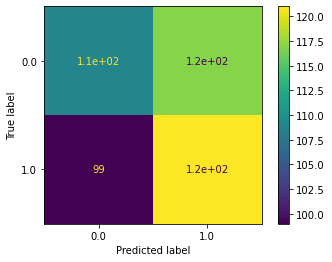

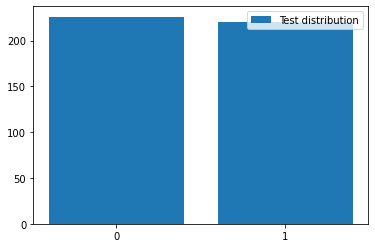

In [42]:
# Logistic regression
logreg = LogisticRegression(random_state=0,max_iter=1000).fit(x_train, y_train)
plot_results(logreg,x_test, y_test)

### Results Logistic Regression
Logistic regression yields a weighted f1-score of 0.52. 

## Random Forest

              precision    recall  f1-score   support

         0.0       0.59      0.32      0.41       226
         1.0       0.52      0.77      0.62       220

    accuracy                           0.54       446
   macro avg       0.55      0.54      0.52       446
weighted avg       0.55      0.54      0.52       446

Test accuracy: 0.5403587443946188


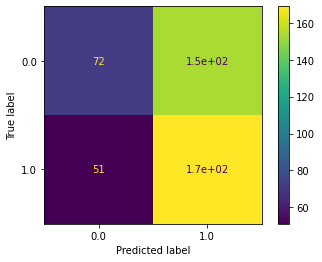

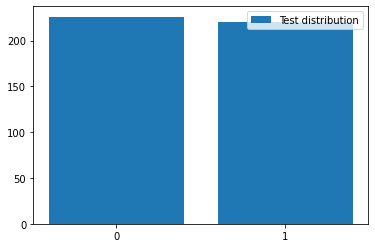

In [45]:
# Random Forest
randomforest = RandomForestClassifier(n_estimators=250).fit(x_train, y_train)
plot_results(randomforest,x_test, y_test)

### Results Random Forest 
Optimizing over the estimators (50, 100, 250, 500, 1000, 5000) gives a weighted average f1-score 0.53 for the best configuration with 250 estimators. It does however vary quite a bit for different runs. 

## XGBoost

              precision    recall  f1-score   support

         0.0       0.56      0.46      0.51       226
         1.0       0.53      0.63      0.58       220

    accuracy                           0.55       446
   macro avg       0.55      0.55      0.54       446
weighted avg       0.55      0.55      0.54       446

Test accuracy: 0.547085201793722


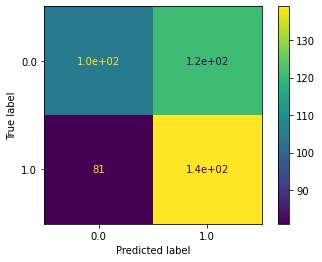

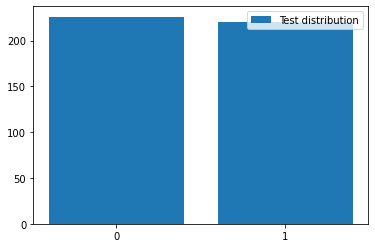

In [48]:
# XGBoost
xgb = XGBClassifier(n_estimators=250).fit(x_train, y_train)
plot_results(xgb,x_test, y_test)

### Results XGBoost

XGBoost gives a similar weighted f1-score to the previous models with 0.54 using 250 estimators, which was the best of the tested (50, 100, 250, 500, 1000, 5000). 

## Neural Network

In [49]:
def create_model(nodes=100, dropout_rate=0.3):
    model = Sequential() 
    model.add(Dense(nodes, input_shape=x_seq_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
    return model 

### Hyperparameters Grid Search
Optimize with respect to batch size, epochs, nodes and dropout rate. Two layers are used. 

In [53]:
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [8, 16, 64, 128]
epochs = [3,4,5,7,10]
nodes = [10, 50, 100, 500]
dropout_rates = [0.3, 0.5]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=nodes, dropout_rate=dropout_rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)
grid_result = grid.fit(x_seq_train, y_seq_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.538573 using {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 7, 'nodes': 50}
0.527162 (0.019449) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 3, 'nodes': 10}
0.515021 (0.021405) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 3, 'nodes': 50}
0.497143 (0.015743) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 3, 'nodes': 100}
0.490006 (0.011868) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 3, 'nodes': 500}
0.489999 (0.008757) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 4, 'nodes': 10}
0.520010 (0.011834) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 4, 'nodes': 50}
0.488567 (0.004148) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 4, 'nodes': 100}
0.515014 (0.029571) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 4, 'nodes': 500}
0.502864 (0.010584) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 5, 'nodes': 10}
0.519277 (0.012013) with: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 5, 'nodes': 50

### Model Training
The model is trained using the hyperparameters found above. 

In [54]:
model = create_model(nodes=grid_result.best_params_['nodes'],
                     dropout_rate=grid_result.best_params_['dropout_rate'])

earlystop = EarlyStopping(monitor='val_loss',
                          patience=2,
                          restore_best_weights=True)
                         

history = model.fit(x_seq_train, y_seq_train,
                    validation_split=0.2,
                    epochs=8,
                    batch_size=grid_result.best_params_['batch_size'],
                    verbose=1)

Train on 1120 samples, validate on 280 samples
Epoch 1/8
1120/1120 [==============================] - 2s 2ms/sample - loss: 1.2732 - acc: 0.5134 - val_loss: 0.7569 - val_acc: 0.4321
Epoch 2/8
1120/1120 [==============================] - 0s 149us/sample - loss: 0.7709 - acc: 0.5188 - val_loss: 0.7283 - val_acc: 0.4679
Epoch 3/8
1120/1120 [==============================] - 0s 127us/sample - loss: 0.7514 - acc: 0.5259 - val_loss: 0.6972 - val_acc: 0.5393
Epoch 4/8
1120/1120 [==============================] - 0s 85us/sample - loss: 0.6897 - acc: 0.5804 - val_loss: 0.7027 - val_acc: 0.5250
Epoch 5/8
1120/1120 [==============================] - 0s 92us/sample - loss: 0.6965 - acc: 0.5884 - val_loss: 0.8699 - val_acc: 0.4429
Epoch 6/8
1120/1120 [==============================] - 0s 115us/sample - loss: 0.7092 - acc: 0.5696 - val_loss: 0.7028 - val_acc: 0.5357
Epoch 7/8
1120/1120 [==============================] - 0s 116us/sample - loss: 0.6857 - acc: 0.5607 - val_loss: 0.7299 - val_acc: 0.539

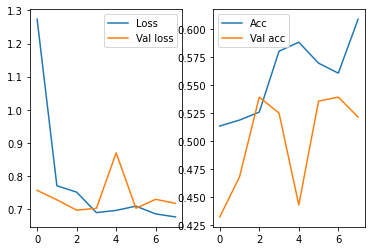

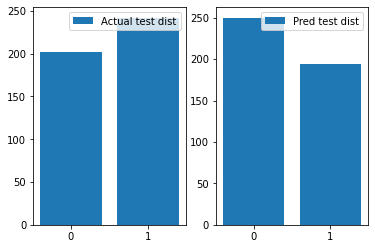

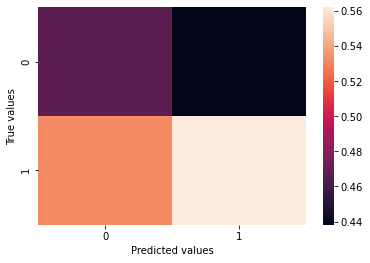

              precision    recall  f1-score   support

         0.0       0.47      0.58      0.52       202
         1.0       0.56      0.45      0.50       242

    accuracy                           0.51       444
   macro avg       0.51      0.51      0.51       444
weighted avg       0.52      0.51      0.51       444



In [55]:
plot_results_nn(history, model)

##  Summary
None of the models performed significantly better than the other. 

| Model | Weighted f1-score | Test Accuracy |
|------|------| ----|
| Logistic Regression  | 0.52 | 0.516 |
| Random Forest  | 0.52 | 0.540 |
| XGBoost  | 0.54 | 0.547 |
| Neural Network  | 0.52 | |